# Assignment 4: Neural Networks

---

## Task 1) Skip-grams

Tomas Mikolov's [original paper](https://arxiv.org/abs/1301.3781) for word2vec is not very specific on how to actually compute the embedding matrices.
Xin Ron provides a much more detailed [walk-through](https://arxiv.org/pdf/1411.2738.pdf) of the math, I recommend you go through it before you continue with this assignment.
Now, while the original implementation was in C and estimates the matrices directly, in this assignment, we want to use PyTorch (and autograd) to train the matrices.
There are plenty of example implementations and blog posts out there that show how to do it, I particularly recommend [Mateusz Bednarski's](https://towardsdatascience.com/implementing-word2vec-in-pytorch-skip-gram-model-e6bae040d2fb) version. Familiarize yourself with skip-grams and how to train them using pytorch.

### Data

Download the `theses.csv` data set from the `Supplemental Materials` in the `Files` section of our Microsoft Teams group.
This dataset consists of approx. 3,000 theses topics chosen by students in the past.
Here are some examples of the file content:

```
27.10.94;14.07.95;1995;intern;Diplom;DE;Monte Carlo-Simulation für ein gekoppeltes Round-Robin-System;
04.11.94;14.03.95;1995;intern;Diplom;DE;Implementierung eines Testüberdeckungsgrad-Analysators für RAS;
01.11.20;01.04.21;2021;intern;Bachelor;DE;Landessprachenerkennung mittels X-Vektoren und Meta-Klassifikation;
```

### Basic Setup

For the upcoming assignments on Neural Networks, we'll be heavily using [PyTorch](https://pytorch.org) as go-to Deep Learning library.
If you're not already familiar with PyTorch, now's the time to get started with it.
Head over to the [Basics](https://pytorch.org/tutorials/beginner/basics/intro.html) and gain some understanding about the essentials.
Before starting this assignment, make sure you've got PyTorch installed in your working environment. 
It's a quick setup, and you'll find all the instructions you need on the PyTorch website.
As always, you can use [NumPy](https://numpy.org) and [Pandas](https://pandas.pydata.org) for data handling etc.

*In this Jupyter Notebook, we will provide the steps to solve this task and give hints via functions & comments. However, code modifications (e.g., function naming, arguments) and implementation of additional helper functions & classes are allowed. The code aims to help you get started.*

---

In [2]:
# Dependencies
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
import torch

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Annika\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Prepare the Data

1.1 Spend some time on preparing the dataset. It may be helpful to lower-case the data and to filter for German titles. The format of the CSV-file should be:

```
Anmeldedatum;Abgabedatum;JahrAkademisch;Art;Grad;Sprache;Titel;Abstract
```

1.2 Create the vocabulary from the prepared dataset. You'll need it for the initialization of the matrices and to map tokens to indices.

1.3 Generate the training pairs with center word and context word. Which window size do you choose?

In [3]:
def load_theses_dataset(filepath):
    """Loads all theses instances and returns them as a dataframe."""
    ### YOUR CODE HERE
    
    df = pd.read_csv(filepath, sep=";")  
    return df
    raise NotImplementedError()
    
    ### END YOUR CODE

In [4]:
def preprocess(dataframe):
    """Preprocesses and tokenizes the given theses titles for further use."""
    ### YOUR CODE HERE
    
    dataframe["Titel"] = dataframe["Titel"].apply(lambda x: x.replace("-", " ").replace("\"", "").replace("(", "").replace(")", "").lower())
    dataframe['Titel'] = dataframe['Titel'].apply(lambda x: nltk.word_tokenize(x, language="german"))
    
    return dataframe["Titel"]
    raise NotImplementedError()
    
    ### END YOUR CODE

In [5]:
def create_training_pairs(data, word2idx, window_size):
    """Creates training pairs based on skip-grams for further use."""
    ### YOUR CODE HERE
    
    idx_pairs = []
    
    for title in data:
        indices = [word2idx[word] for word in title]
        # for each word, threated as center word
        for center_word_pos in range(len(indices)):
            # for each window position
            for w in range(-window_size, window_size + 1):
                context_word_pos = center_word_pos + w
                # make soure not jump out sentence
                if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                    continue
                context_word_idx = indices[context_word_pos]
                idx_pairs.append((indices[center_word_pos], context_word_idx))

    idx_pairs = np.array(idx_pairs)
    
    return idx_pairs
    raise NotImplementedError()
    
    ### END YOUR CODE

In [14]:
path = "D:/Dev/python/seqlrn-assignments/4-nnet/data/theses2022.csv"
dataframe = load_theses_dataset(path)
tokenized_data = preprocess(dataframe)

vocabulary = []
for title in tokenized_data.tolist():
    for token in title:
        if token not in vocabulary:
            vocabulary.append(token)
word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

training_pairs = create_training_pairs(tokenized_data, word2idx, 2)

### Train and Analyze

2.1 Implement and train the word2vec model with your training data.

2.2 Implement a method to find the top-k similar words for a given word (token).

2.3 Analyze: What are the most similar words to "Konzeption", "Cloud" and "virtuelle"?

In [7]:
### TODO: 2.1 Implement and train the word2vec model.

### YOUR CODE HERE

# Input layer
def get_input_layer(word_idx):
    x = torch.zeros(len(vocabulary)).float()
    x[word_idx] = 1.0
    return x

embedding_dims = 5
# embedding matrix
W1 = torch.randn(embedding_dims, len(vocabulary), requires_grad=True)
W2 = torch.randn(len(vocabulary), embedding_dims, requires_grad=True)
num_epochs = 100
learning_rate = 0.001

for epo in range(0, num_epochs):
    loss_val = 0
    for data, target in training_pairs:
        x = get_input_layer(data)
        y_true = torch.from_numpy(np.array([target])).long()
        
        z1 = torch.matmul(W1, x)
        z2 = torch.matmul(W2, z1)
        
        log_softmax = torch.nn.functional.log_softmax(z2, dim=0)
        
        loss = torch.nn.functional.nll_loss(log_softmax.view(1,-1), y_true)
        loss_val += loss.item()
        loss.backward()
        W1.data -= learning_rate * W1.grad.data
        W2.data -= learning_rate * W2.grad.data

        W1.grad.data.zero_()
        W2.grad.data.zero_()
    if epo % 10 == 0:    
        print(f'Loss at epo {epo}: {loss_val/len(training_pairs)}')


### END YOUR CODE

Loss at epo 0: 10.59000958763644
Loss at epo 10: 8.559524382273628
Loss at epo 20: 7.920549775738404
Loss at epo 30: 7.574670487644702
Loss at epo 40: 7.34671027150374
Loss at epo 50: 7.179373124177464
Loss at epo 60: 7.049853975234736
Loss at epo 70: 6.945960865182152
Loss at epo 80: 6.8604856334998745
Loss at epo 90: 6.789036347167935


In [24]:
### TODO: 2.2 Implement a method to find the top-k similar words.

### YOUR CODE HERE

def get_top_k_similar(word, k):
    word_vector = torch.matmul(W1, get_input_layer(word2idx[word]))
    similars = []
    for (idx, w) in enumerate(vocabulary):
        if w != word:
            w_vector = torch.matmul(W1, get_input_layer(word2idx[w]))
            sim = torch.nn.functional.cosine_similarity(word_vector, w_vector, dim=0)
            similars.append((w, sim))
            
    similars.sort(reverse=True, key=lambda x: x[1])       
    return similars[:k]
    raise NotImplementedError()

### END YOUR CODE

In [25]:
### TODO: 2.3 Find the most similar words for "Konzeption", "Cloud" and "virtuelle".

### YOUR CODE HERE

print(get_top_k_similar("konzeption", 5))   
print(get_top_k_similar("cloud", 5))  
print(get_top_k_similar("virtuelle", 5))   

### END YOUR CODE

[('konzeptionierung', tensor(0.9881, grad_fn=<SumBackward1>)), ('entwurf', tensor(0.9878, grad_fn=<SumBackward1>)), ('elementfunktion', tensor(0.9866, grad_fn=<SumBackward1>)), ('statussicht', tensor(0.9843, grad_fn=<SumBackward1>)), ('decentralized', tensor(0.9827, grad_fn=<SumBackward1>))]
[('klinik', tensor(0.9933, grad_fn=<SumBackward1>)), ('potentials', tensor(0.9893, grad_fn=<SumBackward1>)), ('global', tensor(0.9887, grad_fn=<SumBackward1>)), ('gestaltung', tensor(0.9886, grad_fn=<SumBackward1>)), ('projektaktivitätsdaten', tensor(0.9878, grad_fn=<SumBackward1>))]
[('grafana', tensor(0.9983, grad_fn=<SumBackward1>)), ('plugin', tensor(0.9873, grad_fn=<SumBackward1>)), ('beratung', tensor(0.9848, grad_fn=<SumBackward1>)), ('realization', tensor(0.9846, grad_fn=<SumBackward1>)), ('mint', tensor(0.9818, grad_fn=<SumBackward1>))]


### Play with the Embeddings

3.1 Use the computed embeddings: Can you identify the most similar theses for some examples?

3.2 Visualize the embeddings for a subset of theses using [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). You can use [Scikit-Learn](https://scikit-learn.org/stable/) and [Matplotlib](https://matplotlib.org) or [Seaborn](https://seaborn.pydata.org).

In [50]:
### TODO: 3.1 Compute the embeddings for the theses and transform with TSNE.

### YOUR CODE HERE

import numpy as np
from sklearn.manifold import TSNE

sample_size = 500
sample_idx = np.random.choice(len(tokenized_data), sample_size)
samples = [tokenized_data[idx] for idx in sample_idx]

# embedding of sample theses
embeddings = []
for title in samples:
    title_embedding = torch.zeros(embedding_dims)
    for word in title:
        title_mat = torch.matmul(W1,get_input_layer(word2idx[word])).detach()
        title_embedding += title_mat.numpy()
    embeddings.append(title_embedding)

# tsne
tsne = TSNE(n_components=2, perplexity=embedding_dims).fit_transform(np.array(embeddings))

# loop
similarities = []
for i_idx in range(0, sample_size):
    for j_idx in range(i_idx+1, sample_size):
        score = np.dot(tsne[i_idx], tsne[j_idx])
        similarities.append((i_idx, j_idx, score))
similarities.sort(reverse=True, key=lambda x: x[2])

# print findings
for i_idx, j_idx, score in similarities[0:10]:
    print(i_idx, j_idx, score, ' ')
    print(' '.join(tokenized_data[sample_idx[i_idx]]))
    print(' '.join(tokenized_data[sample_idx[j_idx]]))
    print('--------------')

### END YOUR CODE

108 480 6086.2993  
analyse von abhängigkeiten in der softwareentwicklung der datev eg im geschäftsfeld der personalwirtschaft und konzeptionierung von maßnahmen zur reduzierung der durchlaufzeiten von projekten
analyse von abhängigkeiten in der softwareentwicklung der datev eg im geschäftsfeld der personalwirtschaft und konzeptionierung von maßnahmen zur reduzierung der durchlaufzeiten von projekten
--------------
440 480 5926.1143  
entwicklung einer effizienten vorgehensweise zur analyse technischer schulden des software produkts „ zahlungsverkehr on premise “ der datev eg unter verwendung von architekturanalysewerkzeugen
analyse von abhängigkeiten in der softwareentwicklung der datev eg im geschäftsfeld der personalwirtschaft und konzeptionierung von maßnahmen zur reduzierung der durchlaufzeiten von projekten
--------------
108 440 5908.904  
analyse von abhängigkeiten in der softwareentwicklung der datev eg im geschäftsfeld der personalwirtschaft und konzeptionierung von maßnahmen

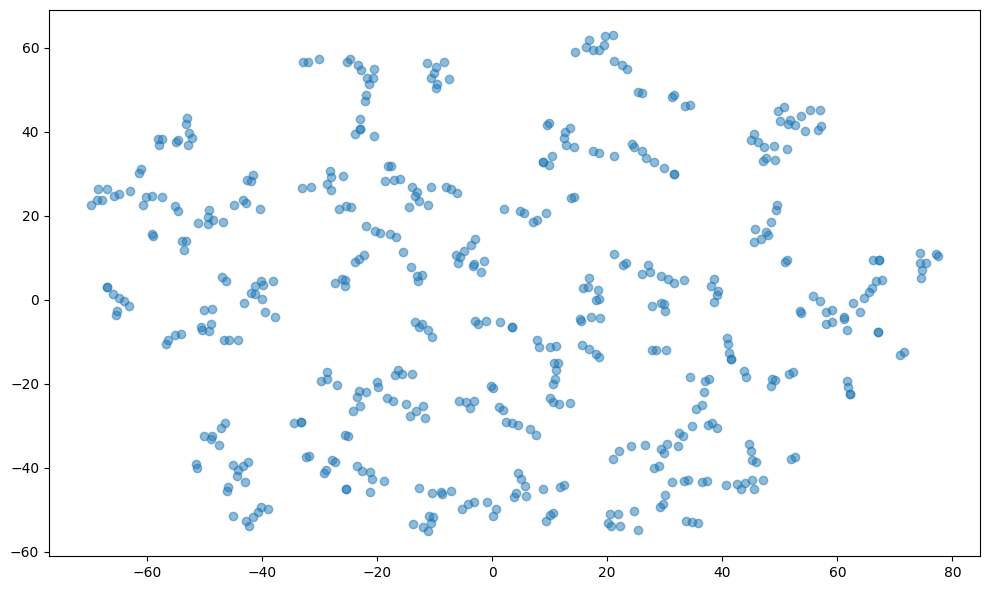

In [52]:
### TODO: 3.2 Visualize the samples in the 2D space.

### YOUR CODE HERE

import matplotlib.pyplot as plt
# Extract indices (dates) and scores from data
indices1 = [s[0] for s in similarities]
indices2 = [s[1] for s in similarities]
scores = [s[2] for s in similarities]

# Plot the graph
plt.figure(figsize=(10, 6))

plt.scatter(tsne[:, 0], tsne[:, 1], alpha=0.5)
plt.tight_layout()
plt.show()

### END YOUR CODE